# JSC370 Class 
## January 23, 2020

## Assignment #1

- Gathering the data
- Defining the question
- Data Analysis


# Gathering the Data

## Data Sources

- [A dataset of publication records for Nobel laureates](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/6NJ5RN). 

- [Crossref REST API](https://github.com/CrossRef/rest-api-doc) contains information on publications such as number of citations.  There are several excellent libraries that can be used to access this API such as [habenaro](https://github.com/sckott/habanero), and [rcrossref](https://github.com/ropensci/rcrossref).  Publication information for a publication from Nobel Laureate [J. Stoddart](https://www.nobelprize.org/prizes/chemistry/2016/stoddart/facts/) with [doi](https://en.wikipedia.org/wiki/Digital_object_identifier) `10.1021/ja00013a096` is obtained below using `habanero`.

- [The Nobel Prize Developer Zone](https://www.nobelprize.org/about/developer-zone-2/).  Endpoints for the API contain information on Laureates and Nobel Prizes. 


# Publications of Nobel Laureates 

- Download the data and read it into a dataframe using `pandas`


In [9]:
import pandas as pd
chempapers = pd.read_csv('chempubrecord.csv')
chempapers.head()

,Laureate ID,Laureate name,Prize year,Title,Pub year,Paper ID,DOI,Journal,Affiliation,Is prize-winning paper
0,20001,"stoddart, j",2016,a molecular shuttle,1991,1.976039e+09,10.1021/ja00013a096,journal of the american chemical society,northwestern university,YES
1,20001,"stoddart, j",2016,chemical synthesis of nanostructures,1993,1.963538e+09,10.1557/PROC-330-57,mrs proceedings,northwestern university,NO
2,20001,"stoddart, j",2016,formation and x ray crystal structure of pt h2...,1981,1.963552e+09,10.1039/C39810000851,journal of the chemical society chemical commu...,northwestern university,NO
3,20001,"stoddart, j",2016,single walled carbon nanotubes under the influ...,2005,2.095637e+09,10.1002/smll.200400070,small,northwestern university,NO
4,20001,"stoddart, j",2016,synthesis of medium heterocyclic rings from 6 ...,1974,2.095679e+09,10.1016/S0008-6215(00)82105-9,carbohydrate research,northwestern university,NO


# Data on Publications

- Use Crossref API.

In [10]:
# Get DOI for first pub in Chem data
print('The DOI for ',chempapers['Title'][0], 'is:', chempapers['DOI'][0], '\n')

from habanero import counts

# Get number of citations for paper
c = counts.citation_count(doi = chempapers['DOI'][0])

print('The number of times ',chempapers['Title'][0], 'was cited is:', c)

The DOI for  a molecular shuttle is: 10.1021/ja00013a096 

The number of times  a molecular shuttle was cited is: 442


- Number of authors

In [72]:
from habanero import cn
pub1 = cn.content_negotiation(ids =  chempapers['DOI'][0])
print(pub1)

@article{Anelli_1991,
	doi = {10.1021/ja00013a096},
	url = {https://doi.org/10.1021%2Fja00013a096},
	year = 1991,
	month = {jun},
	publisher = {American Chemical Society ({ACS})},
	volume = {113},
	number = {13},
	pages = {5131--5133},
	author = {Pier Lucio Anelli and Neil Spencer and J. Fraser Stoddart},
	title = {A molecular shuttle},
	journal = {Journal of the American Chemical Society}
}


# Nobel Laureate Data

- Use [Nobel Prize API](https://www.nobelprize.org/about/developer-zone-2/)
- Look at [documentation/examples](https://app.swaggerhub.com/apis/NobelMedia/NobelMasterData/2)

In [22]:
url = 'http://api.nobelprize.org/2.0/laureates?name=stoddart&format=csv&csvLang=en'
stodd_dat = pd.read_csv(url)
stodd_dat

,id,name,gender,birthdate,birthplace,deathdate,deathplace,category,year,share,overallmotivation,motivation,affiliations
0,932,Sir J. Fraser Stoddart,male,1942-05-24,Edinburgh United Kingdom,NaN,NaN,Chemistry,2016,1/3,NaN,for the design and synthesis of molecular mach...,Northwestern University; Evanston IL USA


- How can you obtain information for the Laureates in `chempapers` data?
- `chempapers` doesn't use the same ID as Nobel  API. 

## How can we extract last name from this string?

In [23]:
chempapers['Laureate name'][0]

'stoddart, j'

In [67]:
print(chempapers.loc[0]['Title'], 'was published in', chempapers.loc[0]['Pub year'])

# Laureate's Birthday
# convert to datetime using: to_datetime()
bday = pd.to_datetime(stodd_dat['birthdate'], yearfirst = True, format = '%Y-%m-%d')
print('Stoddart was born on', bday[0].month_name(), bday[0].day,',', bday[0].year)

# Age of Laureate when paper is published
print('He was',chempapers.loc[0]['Pub year'] - bday[0].year, 'years old when he published:',chempapers.loc[0]['Title'])

a molecular shuttle was published in 1991
Stoddart was born on May 24 , 1942
He was 49 years old when he published: a molecular shuttle


# Defining the Question

**How will you assess:**

Among Nobel Prize winner's in Physics, Chemistry, and Biology, what is the relationship between scientific impact of a paper and the timing of the paper during a scientist's career?  Does this relationship depend on a scientist's age, gender, team size, or prize category?

- What is the dependent variable?
- What are the features/explanatory variables/covariates?

# Poisson Regression

This example is from [UCLA's IDRE](https://stats.idre.ucla.edu/r/dae/poisson-regression/).

`num_awards`: the outcome variable and indicates the number of awards earned by students at a high school in a year, 

`math`: a continuous predictor variable and represents students’ scores on their math final exam, and 

`prog`: is a categorical predictor variable with three levels indicating the type of program in which the students were enrolled. It is coded as 1 = “General”, 2 = “Academic” and 3 = “Vocational”. Let’s start with loading the data and looking at some descriptive statistics.

In [73]:
%load_ext rpy2.ipython

In [81]:
%%R
options(warn=-1)
library(tidyverse)
p <- read.csv("https://stats.idre.ucla.edu/stat/data/poisson_sim.csv")
#p <- within(p, {
#  prog <- factor(prog, levels=1:3, labels=c("General", "Academic", 
#                                                     "Vocational"))
#  id <- factor(id)
#})

awards <- p %>% mutate(prog = factor(prog, levels=1:3, labels=c("General", "Academic", "Vocational")), 
            id = factor(id))
summary(awards)

       id        num_awards           prog          math      
 1      :  1   Min.   :0.00   General   : 45   Min.   :33.00  
 2      :  1   1st Qu.:0.00   Academic  :105   1st Qu.:45.00  
 3      :  1   Median :0.00   Vocational: 50   Median :52.00  
 4      :  1   Mean   :0.63                    Mean   :52.65  
 5      :  1   3rd Qu.:1.00                    3rd Qu.:59.00  
 6      :  1   Max.   :6.00                    Max.   :75.00  
 (Other):194                                                  


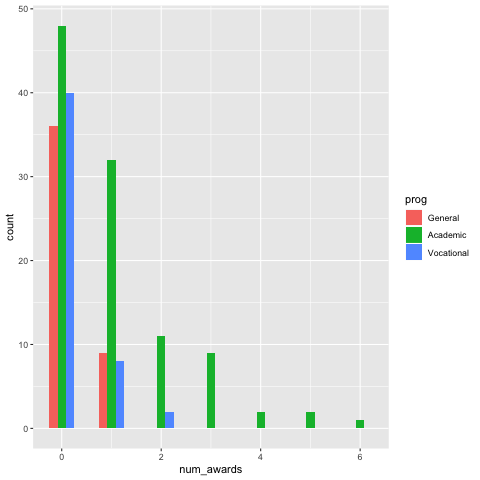

In [83]:
%%R
awards %>% ggplot(aes(num_awards, fill = prog)) + geom_histogram(binwidth=.5, position="dodge")

In [121]:
%%R

preg_mod <- glm(num_awards ~ prog , family = "poisson", data = awards)
print(summary(preg_mod))
#confint(preg_mod)


Call:
glm(formula = num_awards ~ prog, family = "poisson", data = awards)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4142  -0.6928  -0.6325   0.0000   3.3913  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -1.6094     0.3333  -4.828 1.38e-06 ***
progAcademic     1.6094     0.3473   4.634 3.59e-06 ***
progVocational   0.1823     0.4410   0.413    0.679    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 287.67  on 199  degrees of freedom
Residual deviance: 234.46  on 197  degrees of freedom
AIC: 416.51

Number of Fisher Scoring iterations: 6



In [120]:
import numpy as np
np.round(np.exp(1.6094),2), np.round(np.exp(0.1823),2)

(5.0, 1.2)

## Interpretation

In [108]:
%%R 

awards %>% group_by(prog) %>% 
           summarise (n = n(), Total_awards = sum(num_awards)) %>%
           mutate(Risk = Total_awards/n)

# A tibble: 3 x 4
  prog           n Total_awards  Risk
  <fct>      <int>        <int> <dbl>
1 General       45            9  0.2 
2 Academic     105          105  1   
3 Vocational    50           12  0.24


In [111]:
1/0.2, 0.24/0.2

(5.0, 1.2)

In [122]:
%%R

preg_mod <- glm(num_awards ~ prog + math, family = "poisson", data = awards)
print(summary(preg_mod))


Call:
glm(formula = num_awards ~ prog + math, family = "poisson", data = awards)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2043  -0.8436  -0.5106   0.2558   2.6796  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -5.24712    0.65845  -7.969 1.60e-15 ***
progAcademic    1.08386    0.35825   3.025  0.00248 ** 
progVocational  0.36981    0.44107   0.838  0.40179    
math            0.07015    0.01060   6.619 3.63e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 287.67  on 199  degrees of freedom
Residual deviance: 189.45  on 196  degrees of freedom
AIC: 373.5

Number of Fisher Scoring iterations: 6



A one-unit increase in math will result in a multiplicative effect of $\exp(0.07015) = 1.07$ on the rate of awards while accounting for program. In other words, the percent change in the number of awards increases by 7% for every unit increase in math.

# Extensioning Poisson Regression ...

- The data sets contain multiple observations per Laureate.
- The Poisson regression model treats each publication as independent.
- A random coefficient model accounts for both within Laureate variability and between Laureate variability.
- The R package [`lme4`](https://cran.r-project.org/web/packages/lme4/index.html).  A nice tutorial style document is available [here](http://lme4.r-forge.r-project.org/slides/2009-07-07-Rennes/3Longitudinal-4.pdf).

In [123]:
np.exp(0.07015)

1.072669069547725